In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'english-handwritten-characters-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1176843%2F1972672%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241003%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241003T132224Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dab6323dcf79f0e2d4a060d811b77ef6f747bf4a7c1f18db457b179ac486359148efc536c68d99fddb4f47d7c0f91873315d929df568d2e5dae027f7595d9a329a585408608e4b188fddf016b3917c95748a01c28fb2ab02c00e6405cf9cb5c503de19be1b0d91e39021cdaadaf5cb65f3f44654f7b854596d437605bd3d61eaa8bc89e7f45ed18b29c88cbf0a4561518f3dabfc9c3f977f35fb2daf8bb5873c7ef989fb58c13de1482cef3712a29f2e9a6500e38e773cf30e5cb7e92e49201883621bcb80d153f15ebe6e5b2167568b872593aee0eb4b2b18ba7a5c2c889f778c8adb4d3a0ad4f1bd805039065a8a123292bc1314a0fd63e90c9a0d3d0d4f8f5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 13694607 bytes downloaded
Downloaded and uncompressed: english-handwritten-characters-dataset
Data source import complete.


In [3]:
!pip install -q tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 94.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization, Input, Activation, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import tensorflowjs as tfjs
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shutil

In [5]:
# Read in Y labels from CSV

label_csv = '/kaggle/input/english-handwritten-characters-dataset/english.csv'
df_Y = pd.read_csv(label_csv)

In [6]:
# Read images and write with label to arrays

images_path = "/kaggle/input/english-handwritten-characters-dataset/Img"
images = []
labels = []

for image_path in os.listdir(images_path):
    image = cv.imread(os.path.join(images_path, image_path)).astype('float32') # Read image as a float32 object
    image = cv.resize(image, (64, 64)) # Resize to smaller size for faster train time
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Convert to greyscale for faster train time
    image /= 255.0 # Normalise data

    label_index = os.path.join("Img", image_path) # Get index into df_Y
    label = df_Y[df_Y['image'] == label_index].label.values[0] # Get label value

    # Write into arrays
    images.append(image)
    labels.append(label)

In [7]:
# Convert to np arrays

images = np.array(images)
labels = np.array(labels)

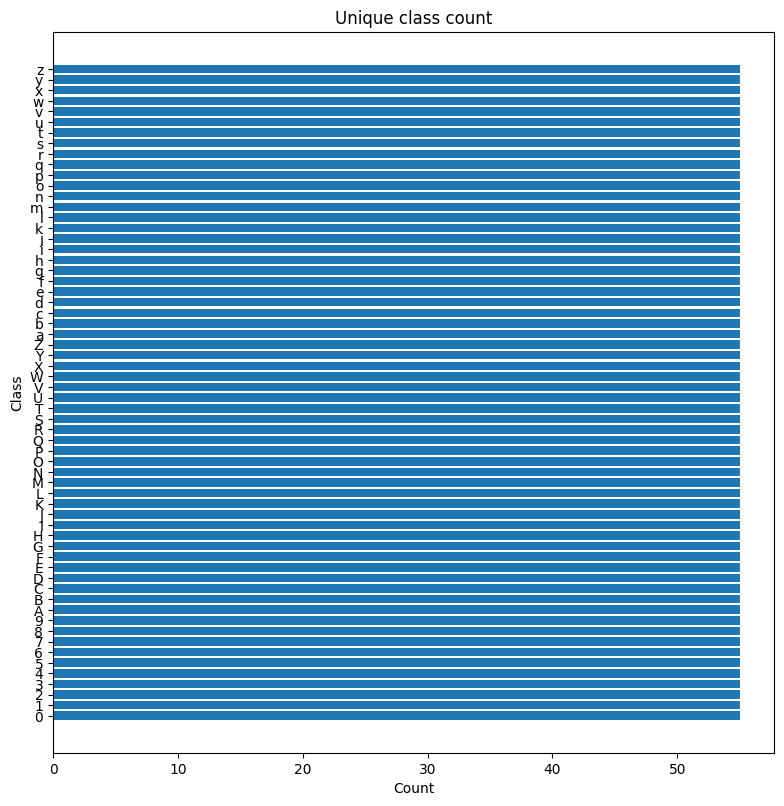

In [8]:
# Visualise the count for each class

unique_class, class_count = np.unique(labels, return_counts=True)

plt.figure(figsize=(8,8))
plt.barh(unique_class, class_count)
plt.tight_layout(pad=2.0)
plt.title("Unique class count")
plt.xlabel("Count")
plt.ylabel("Class")
plt.show()

In [9]:
# Add greyscale dimension for cnn

images = np.expand_dims(images, axis=-1)

In [10]:
# One hot encode the labels

encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

In [11]:
# Define a custom decoder

decoder = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]

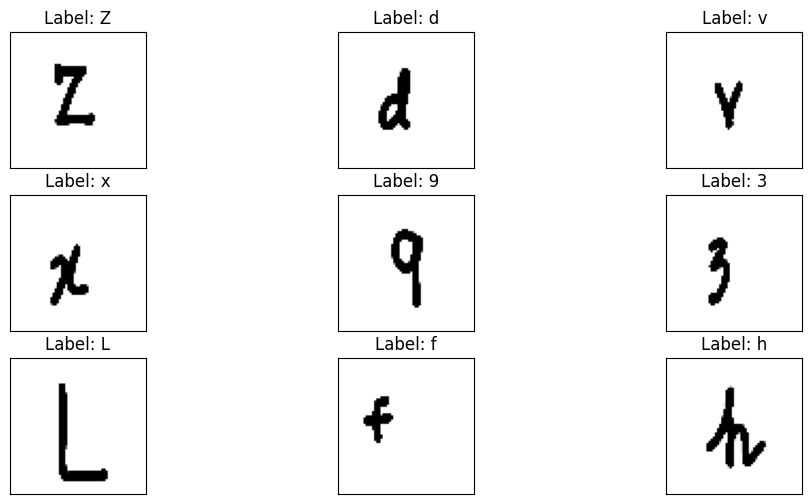

In [12]:
# Plot 9 random images for visualisation

def display_images(rows, cols, images, labels, decoder):
    _, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Label: {decoder[np.where(labels[i]==1)[0][0]]}")

display_images(3, 3, images, labels, decoder)

In [13]:
# Randomly shuffle the data

images, labels = shuffle(images, labels, random_state=0)

In [14]:
# Split the data into train, test and validation sets (70, 15, 15)

X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

In [15]:
# Define augmentation generator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.2,
    zoom_range= 0.2,
    shear_range=0.2,
    fill_mode='nearest',
)

In [16]:
# Load augmented data into arrays

augmented_arr_X = []
augmented_arr_Y = []
number_of_augmentation = 5

for i in range(len(X_train)):
    image_expanded = np.expand_dims(X_train[i], axis=0)
    aug_iter = datagen.flow(image_expanded, batch_size=1)
    augmented_images = [next(aug_iter)[0] for _ in range(number_of_augmentation)]
    augmented_arr_X.extend(augmented_images)
    augmented_arr_Y.extend([Y_train[i]] * number_of_augmentation)

In [17]:
# Set augmented data up for training

X_train = np.array(augmented_arr_X)
Y_train = np.array(augmented_arr_Y)

In [18]:
# Shuffle again

X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

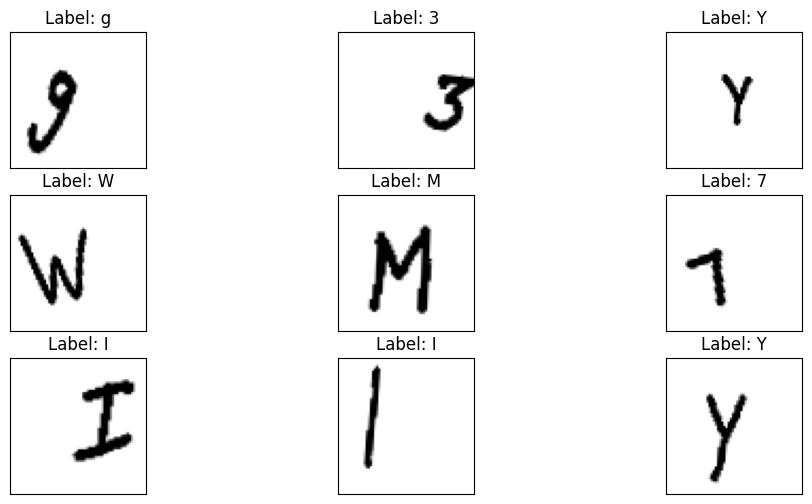

In [19]:
# Display augmented images

display_images(3, 3, X_train, Y_train, decoder)

In [20]:
# Define model

model = Sequential([
    Input(shape=(64, 64, 1)),

    Conv2D(512, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.1),

    Dense(1024, activation='relu'),

    Dense(512, activation='relu'),
    Dropout(0.1),

    Dense(256, activation='sigmoid'),

    Dense(62, activation='softmax')
])

In [21]:
# Visualise model summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 60, 60, 512)         │          13,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 62)                  │          15,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,699,774 (29.37 MB)

 Trainable params: 7,699,774 (29.37 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compile and train the model

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=2, batch_size=16, validation_data=(X_val,Y_val))

Epoch 1/2
746/746 ━━━━━━━━━━━━━━━━━━━━ 1882s 3s/step - accuracy: 0.0180 - loss: 4.1458 - val_accuracy: 0.1331 - val_loss: 3.1766
Epoch 2/2
746/746 ━━━━━━━━━━━━━━━━━━━━ 1856s 2s/step - accuracy: 0.1469 - loss: 3.0327 - val_accuracy: 0.2975 - val_loss: 2.1610


In [23]:
# Train and validation accuracy

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

[]

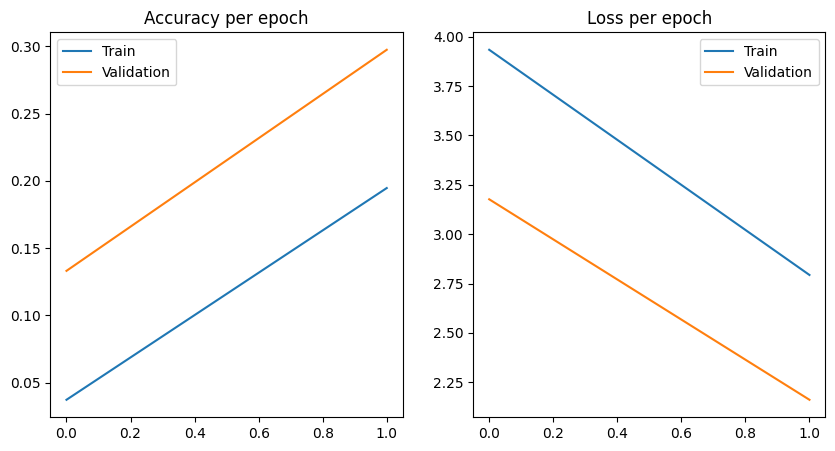

In [24]:
# Plot the accuracy and loss

_, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))

# Plot accuracy
axes[0].plot(train_accuracy)
axes[0].plot(validation_accuracy)
axes[0].legend(['Train', 'Validation'])
axes[0].set_title("Accuracy per epoch")

# Plot loss
axes[1].plot(train_loss)
axes[1].plot(validation_loss)
axes[1].legend(['Train', 'Validation'])
axes[1].set_title("Loss per epoch")

plt.plot()

In [25]:
# Get test predictions

Y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


In [26]:
# Find accuracy of the model

y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.3457


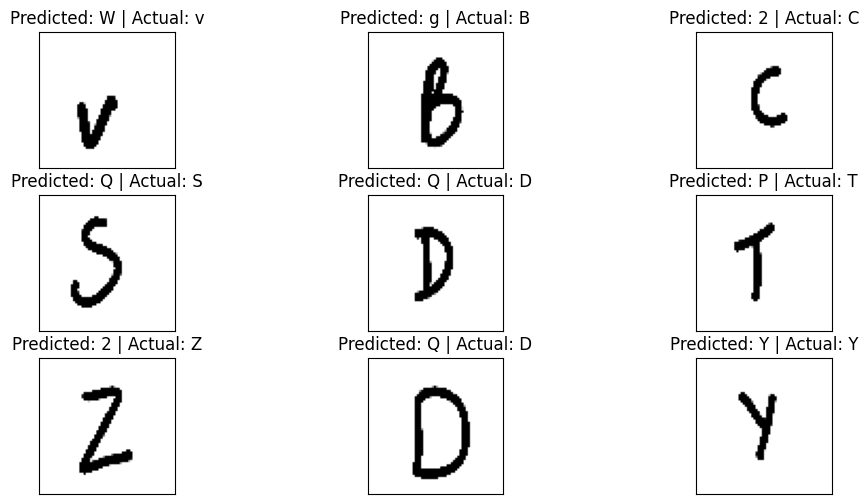

In [27]:
_, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_test[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Predicted: {decoder[y_pred_classes[i]]} | Actual: {decoder[y_true[i]]}")

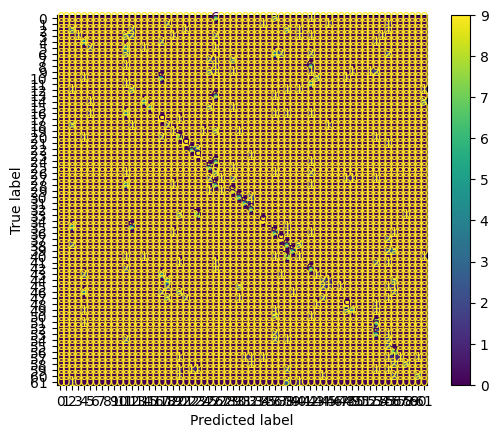

In [28]:
# Plot confusion matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')

In [29]:
# Save model to tfjs format and save as zip

# Save to tfjs format
tfjs.converters.save_keras_model(model, 'model_js')

# Convert output folder to zip
folder_to_zip = 'model_js'
output_zip = 'model_js'
shutil.make_archive(output_zip, 'zip', folder_to_zip)

failed to lookup keras version from the file,
    this is likely a weight only file


'/content/model_js.zip'